In [1]:
import pandas as pd
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
import os
os.chdir('..')

import main
import seaborn as sns
drive_path = r"U:\VEIDB/"
data_path = r"V:\Data"
ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import os
sb.set_style('dark')

In [3]:
""" Define path to results folder. """
results_path = r'E:\data\GRP_optotagged'
if not os.path.isdir(results_path):
    os.mkdir(results_path)

['2P', 'SCEphys', 'VEIDB', 'VEIDBOpenfield', 'mysql', 'performance_schema', 'sys', 'test', 'tutorial']


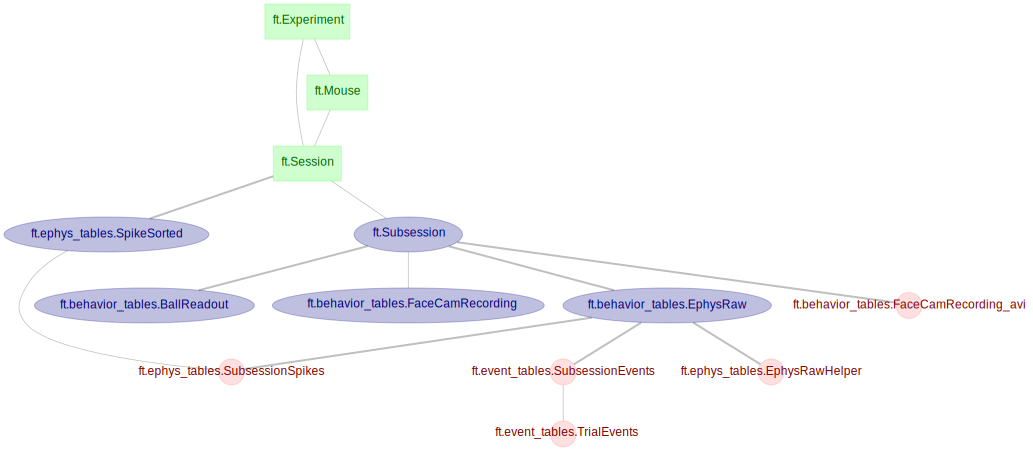

In [4]:
print(dj.list_schemas())
dj.Di(ft.schema)

In [5]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_tables = ft.ephys_tables.EphysRaw()
subsess_events_table = ft.event_tables.SubsessionEvents()

sorted_table = ft.ephys_tables.SpikeSorted()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

In [6]:
# Import local Neuron project
import sys
projects_folder = r'C:\Users\bramn\Documents\Projects'
if os.path.abspath(projects_folder) not in sys.path:
    sys.path.append(os.path.abspath(projects_folder))

import Neuron
from Neuron.datatypes.block import Block
from Neuron.visualization import spikes as vis_spikes
from Neuron.stages.pipeline import Pipeline
from Neuron.stages.firing_rate_estimation import FiringRateEstimation

In [23]:
subsess_spikes_table & {'experiment_id': '01437'}

experiment_id,mouse_id,session_id,subsession_id,subsession_type,start_abs,clusters,cluster_annot,cluster_info
01437,M02,20201214,EXD_1_0001,EXD,0,=BLOB=,=BLOB=,=BLOB=
01437,M02,20201214,EXD_2_0001,EXD,82266191,=BLOB=,=BLOB=,=BLOB=
01437,M02,20201214,EXD_3_0001,EXD,163167587,=BLOB=,=BLOB=,=BLOB=
01437,M02,20201214,OPTS_1_0001,OPTS,0,=BLOB=,=BLOB=,=BLOB=


In [8]:
def get_neural(subsess_key, data_type=None, hz=40):
    unit_info, units = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    block = Block(units_dict=units, unit_info=unit_info).annot_slice(annot='good')
    # Convert to firing rates
#     line = Pipeline()
#     line.add_stage(FiringRateEstimation(fr_type='counts'), binsize=30*(1000/hz), sampling_period=1000/hz) # 30*25 ==> hz=40
#     #     line.add_stage(Downsampling(ds_type='standard'), sz=40)
#     firing_rates = line.execute(block.get_view('spikes'), meta=None)[-1]  
#     block.add_view('counts', firing_rates, hz=hz) # time axis...
    return block

subsess_key = {'experiment_id': '01437', 'mouse_id': 'M02', 'session_id': '20201214'}
subsess_ids = ['EXD_1_0001', 'EXD_2_0001', 'EXD_3_0001']
blocks = []
subsess_trials_triggers = []
common_units = []
for subsess_id in subsess_ids:
    subsess_key['subsession_id'] = subsess_id
    block = get_neural(subsess_key)
    if len(common_units) == 0:
        common_units = list(block.units.keys())
    else:
        common_units = np.intersect1d(common_units, list(block.units.keys()))
    trials_triggers, trials_stimtypes = (subsess_events_table & subsess_key).fetch1('trials', 'trials_stimtypes')
    trials_triggers = [trial for stimtype, trial in zip(trials_stimtypes, trials_triggers) if stimtype=='EXPA'] # select only EXPA trials
    blocks.append(block)
    subsess_trials_triggers.append(trials_triggers)

In [9]:
common_units

array([ 31,  50,  62,  79,  80,  82,  85,  93,  97, 100, 102, 116, 117,
       128, 131, 143, 155, 159, 164, 174, 190, 198, 200, 209, 211, 217,
       218, 221, 228, 229, 231, 232, 235, 243, 250, 254, 256, 262, 276,
       277, 279, 284, 288, 289, 293, 294, 297, 300, 305, 309, 310, 311,
       314, 315, 321, 322, 327, 330, 333, 334, 336, 337, 340, 343, 358,
       375, 381, 387, 388, 393, 400, 408, 409, 410, 422, 436, 439, 446,
       465, 467, 468, 475, 479, 484, 487, 494, 495, 549, 553, 554, 555,
       560, 569, 579, 581, 587, 590, 591, 609, 628, 630, 639, 703, 709,
       710, 715, 720, 731, 751, 753, 756, 766, 784, 786, 787, 794, 795,
       801, 809, 810, 816, 820, 821, 823])

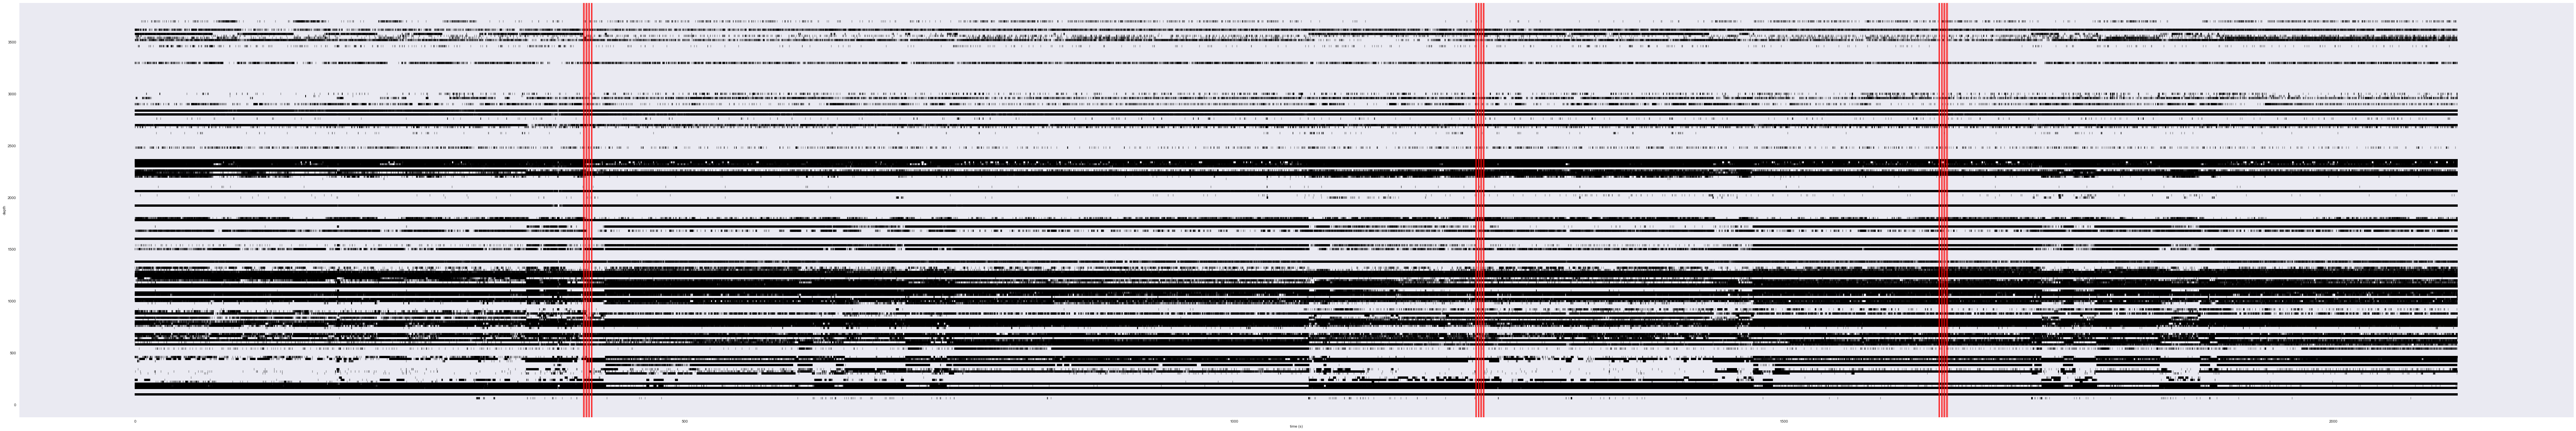

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(120, 20))
vis_spikes.plot_raster(blocks[0], ax, event_times=[trigger for trial in subsess_trials_triggers[0] for stim_pres in trial for trigger in stim_pres])
plt.show()

In [19]:
# Split block into trials
trials = []
for block, trials_triggers in zip(blocks, subsess_trials_triggers):
    for trial_triggers in trials_triggers:
        for stim_triggers in trial_triggers:
#             spikes_sliced = block.unit_slice(common_units).time_slice(stim_triggers[0]/30+16000, stim_triggers[2]/30+16000).get_view('spikes')
            spikes_sliced = block.unit_slice(common_units).time_slice(stim_triggers[0]/30, stim_triggers[2]/30).get_view('spikes')
            print(spikes_sliced.shape)
            spikecounts = [len(unit_spikes) for unit_spikes in spikes_sliced]
            trials.append(spikecounts)

(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)
(124,)


In [20]:
trials = np.array(trials)

In [21]:
trials.shape

(36, 124)

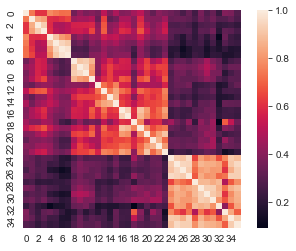

In [22]:
sb.heatmap(np.corrcoef(trials), square=True)
plt.show()

## Spike raster plots

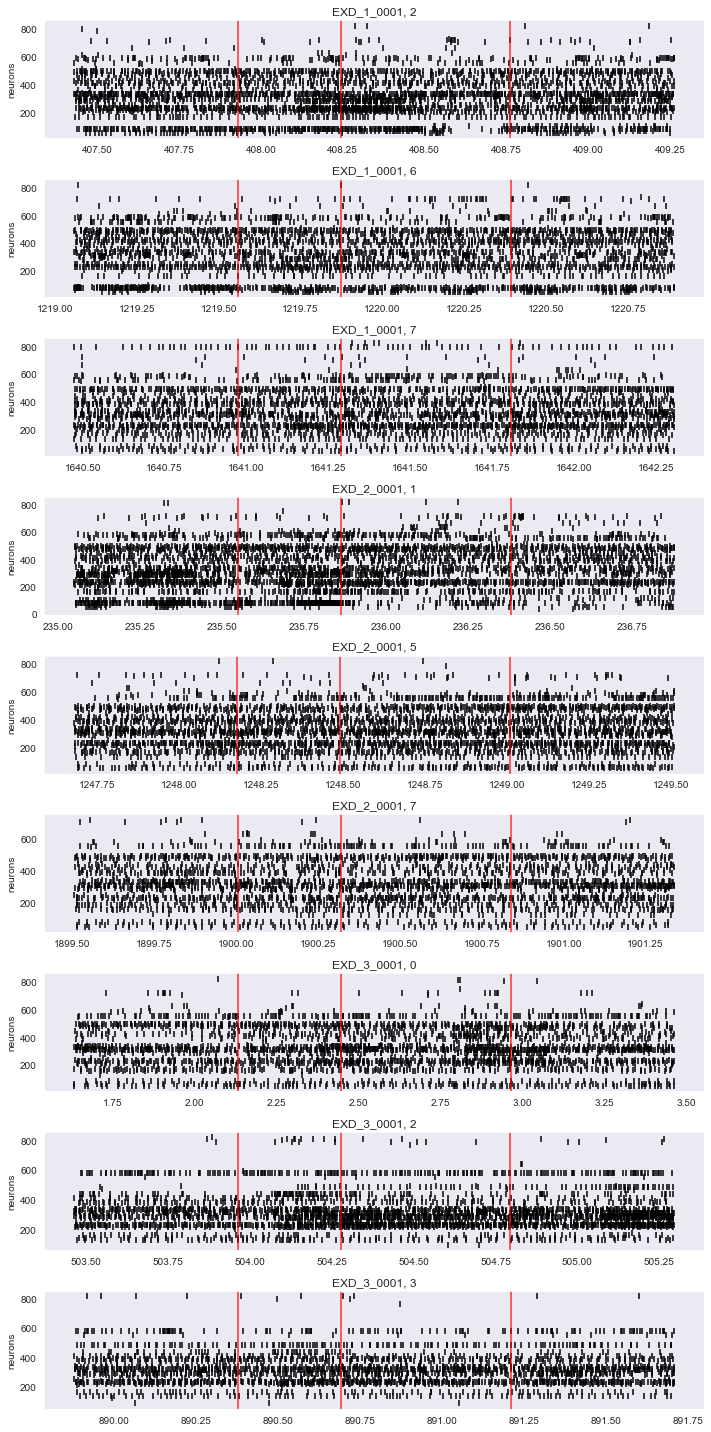

In [99]:
fig, axs = plt.subplots(len(trials_expa), 1, figsize=(10, 20))

for i, trial in enumerate(trials_expa):
#     print(trial)
    clusters, cluster_annot = (subsess_spikes_table & trial).fetch1('clusters', 'cluster_annot')
    clusters_good = filter_clusters(clusters, annot=['good'])
#     plot_spike_raster(clusters, cluster_annot, trial['start'], trial['end'], axs[i])
    plot_spike_raster(clusters_good, trial['events'][0][0]-15000, trial['events'][0][2]+15000, axs[i], trial['events'])
    axs[i].set_title(f"{trial['subsession_id']}, {trial['trial_iter']}")

#     break
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'spikeraster_expa.png'))


## Firing rates

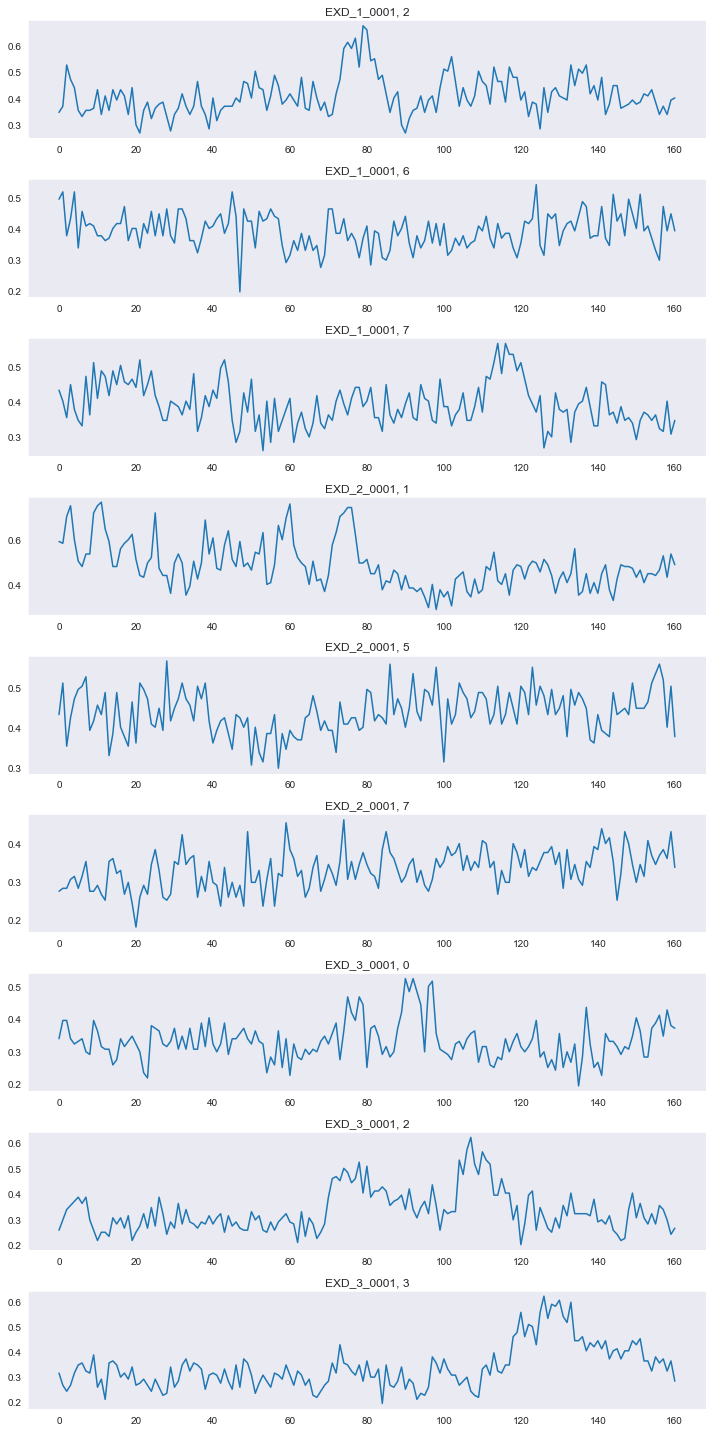

In [111]:
def spikes_2_firingrate(clusters, start, end, n_neurons=1, binsize=30, stride=5):
    first_spike_time = min([s[0] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0])    
    last_spike_time = max([s[-1] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0])    

    fr_clusters = {}
    for i, (c, cl_spike_times) in enumerate(clusters.items()):
        if cl_spike_times is not None:
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            fr, _ = np.histogram(cl_spike_times_sub, bins=np.arange(start, end, (30000/1000)*binsize))
            fr_clusters[c] = fr
    return fr_clusters

def plot_firing_rates(fr_clusters, ax, mean=True, event_times=None):
    trial_frs = []
    for j, (c, firing_rate) in enumerate(fr_clusters.items()):
#         axs[i].plot(np.ones_like(firing_rate)*c*1, firing_rate)
        trial_frs.append(firing_rate)
    ax.plot(np.mean(np.array(trial_frs), axis=0))


fig, axs = plt.subplots(len(trials_expa), 1, figsize=(10, 20))

for i, trial in enumerate(trials_expa):
    clusters, cluster_annot = (subsess_spikes_table & trial).fetch1('clusters', 'cluster_annot')
    clusters_good = filter_clusters(clusters, annot=['good'])
    fr_clusters = spikes_2_firingrate(clusters_good, trial['events'][0][0]-60000, trial['events'][0][2]+60000, binsize=30)
    
    plot_firing_rates(fr_clusters, axs[i])
    axs[i].set_title(f"{trial['subsession_id']}, {trial['trial_iter']}")
    
plt.tight_layout()
plt.show()
# """ Convert spikes to firing rates"""

# last_spike_time = max([s[-1] for s in spikes if isinstance(s, np.ndarray) and len(s)>0])
# firing_rates = np.zeros((len(spikes), int(last_spike_time*(1000/(30000*fr_binsize)))))
# print(last_spike_time)
# print(firing_rates.shape)
# for i, unit_spikes in enumerate(spikes):
#     fr, _ = np.histogram(unit_spikes, bins=np.arange(0, last_spike_time, (30000/1000)*fr_binsize))
#     firing_rates[i] = fr - np.mean(fr)